In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F

from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from rdkit import Chem
from conf_ensemble_dataset import PDBBindConfEnsembleDataset, PlatinumConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from collections import defaultdict
from litschnet import LitSchNet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from rmsd_predictor_evaluator import RMSDPredictorEvaluator

In [2]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# Data preparation

In [3]:
data_dir = 'data/'

In [4]:
dataset = PDBBindConfEnsembleDataset(data_dir)

Creating molecule encoders


100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.48s/it]


In [5]:
sdsupplier = Chem.rdmolfiles.SDMolSupplier(os.path.join(data_dir, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf'))
platinum_mols = [mol for mol in sdsupplier]

In [6]:
platinum_smiles = [Chem.MolToSmiles(mol) for mol in platinum_mols]

In [7]:
dataset_smiles = [Chem.MolToSmiles(data.mol) for data in dataset]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:57: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.42329758405685425}
--------------------------------------------------------------------------------
Grouping data by pdb_id


  1%|▍                                          | 9/901 [00:00<00:10, 81.22it/s]

Starting evaluation


100%|█████████████████████████████████████████| 901/901 [00:09<00:00, 96.14it/s]


Mean loss : 0.43


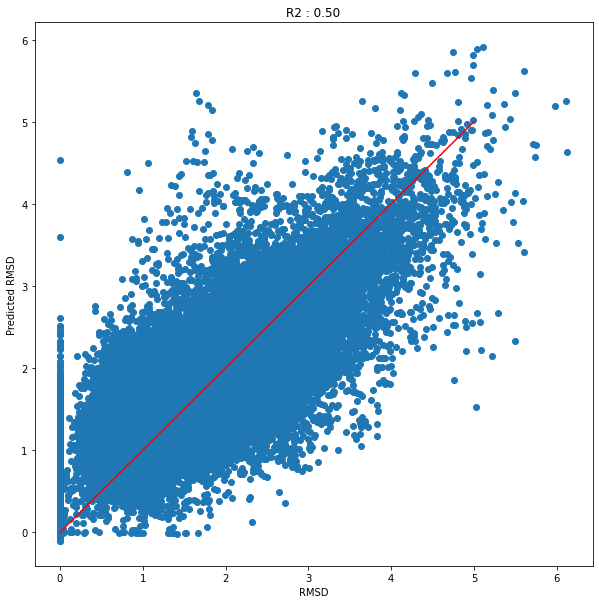

Bioactive ranking accuracy : 0.8135405105438401
Median rank : 0.0


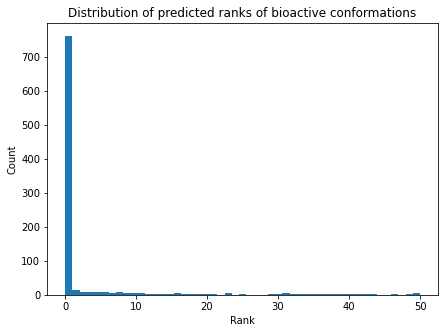

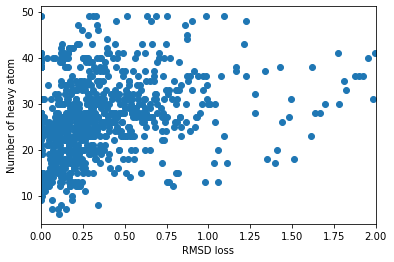

Generated ranking accuracy : 0.1554054054054054
CCDC ranking accuracy : 0.15


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.4638243615627289}
--------------------------------------------------------------------------------
Grouping data by pdb_id


  1%|▍                                          | 9/864 [00:00<00:10, 80.86it/s]

Starting evaluation


100%|█████████████████████████████████████████| 864/864 [00:09<00:00, 93.39it/s]


Mean loss : 0.44


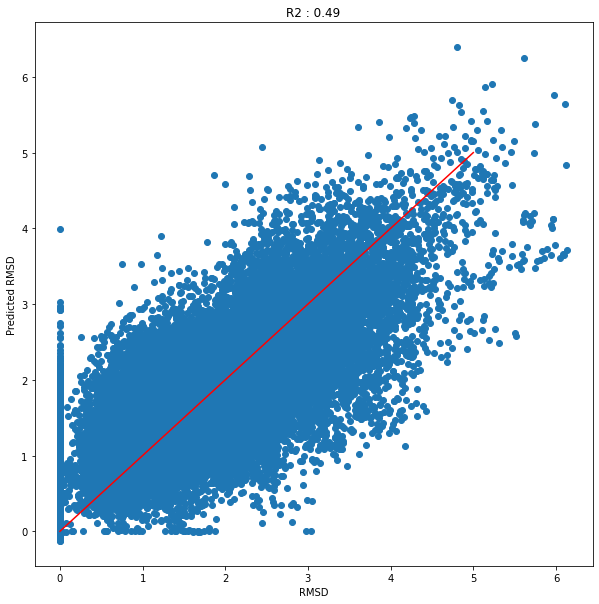

Bioactive ranking accuracy : 0.7905092592592593
Median rank : 0.0


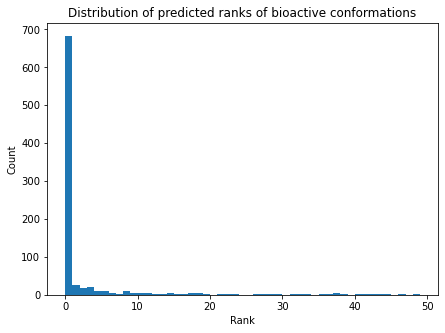

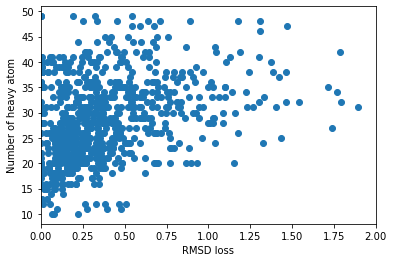

Generated ranking accuracy : 0.13212795549374132
CCDC ranking accuracy : 0.11961057023643949


In [8]:
for iteration in range(2) :
    with open(os.path.join(data_dir, f'train_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, f'val_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        valid_smiles = f.readlines()
        valid_smiles = [smiles.strip() for smiles in valid_smiles]

    with open(os.path.join(data_dir, f'test_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_indices = [i 
                     for i, data in enumerate(dataset) 
                     if dataset_smiles[i] in train_smiles 
                     and dataset_smiles[i] not in platinum_smiles]

    val_indices = [i 
                   for i, data in enumerate(dataset) 
                   if dataset_smiles[i] in valid_smiles 
                   and dataset_smiles[i] not in platinum_smiles]

    test_indices = [i 
                    for i, data in enumerate(dataset) 
                    if dataset_smiles[i] in test_smiles 
                    and dataset_smiles[i] not in platinum_smiles]
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'scaffold_split_{iteration}_8000'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_subset)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.38011643290519714}
--------------------------------------------------------------------------------
Grouping data by pdb_id


  1%|▏                                         | 8/1400 [00:00<00:17, 77.84it/s]

Starting evaluation


100%|██████████████████████████████████████| 1400/1400 [00:11<00:00, 123.90it/s]


Mean loss : 0.24


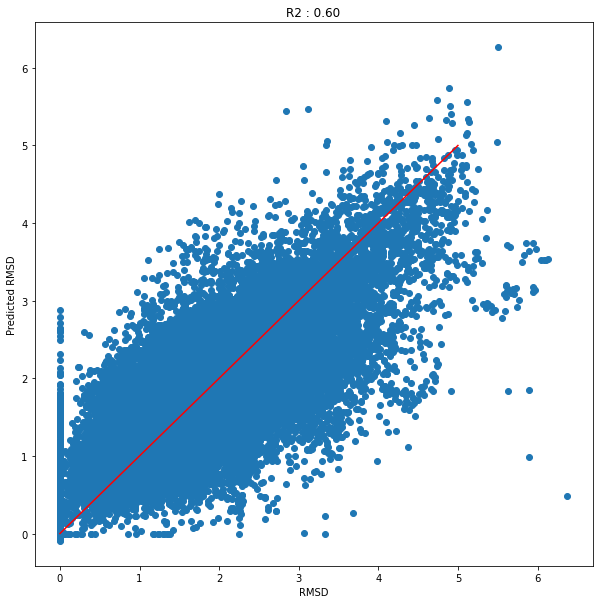

Bioactive ranking accuracy : 0.8985714285714286
Median rank : 0.0


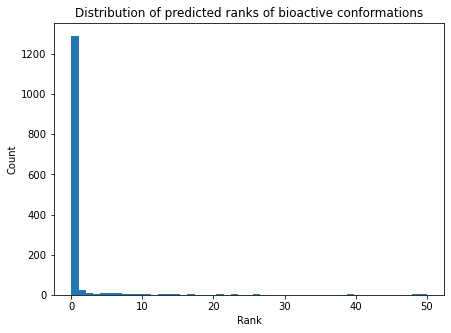

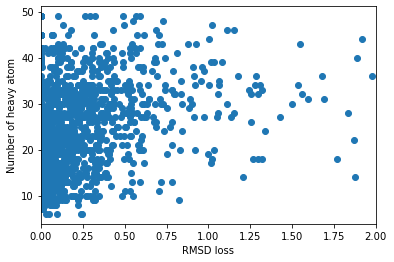

Generated ranking accuracy : 0.16978776529338327
CCDC ranking accuracy : 0.14232209737827714


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | schnet     | SchNet    | 455 K 
1 | leaky_relu | LeakyReLU | 0     
2 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
455 K     Trainable params
0         Non-trainable params
455 K     Total params
1.823     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
for iteration in range(2) :
    with open(os.path.join(data_dir, f'train_smiles_random_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, f'val_smiles_random_split_{iteration}.txt'), 'r') as f :
        valid_smiles = f.readlines()
        valid_smiles = [smiles.strip() for smiles in valid_smiles]

    with open(os.path.join(data_dir, f'test_smiles_random_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_indices = [i 
                     for i, data in enumerate(dataset) 
                     if dataset_smiles[i] in train_smiles 
                     and dataset_smiles[i] not in platinum_smiles]

    val_indices = [i 
                   for i, data in enumerate(dataset) 
                   if dataset_smiles[i] in valid_smiles 
                   and dataset_smiles[i] not in platinum_smiles]

    test_indices = [i 
                    for i, data in enumerate(dataset) 
                    if dataset_smiles[i] in test_smiles 
                    and dataset_smiles[i] not in platinum_smiles]
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'random_split_{iteration}_8000'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_subset)